In [1]:
import numpy as np
import sklearn
import sklearn.tree
import csv
import sklearn.ensemble
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn import linear_model

In [2]:
def normalize(x):
    '''This function nomalizes each columns of the input 2d array.'''
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x_std[x_std == 0] = 1
    x1 = (x - x_mean) / x_std
    return x1

def xgb_test_accuracy(preds_prob, test_label):
    preds_label = preds_prob > 0.5
    accuracy = 0
    for i in range(len(test_label)):
        if preds_label[i] == test_label[i]:
            accuracy += 1
    return accuracy

def xgb_feature_testerror(input_train_data, input_test_data, feature_index):
    X_train = input_train_data[:,[0,feature_index]]
    Y_train = input_train_data[:,382]
    Y_train[Y_train == 2.0] = 0
    X_test = input_test_data[:,[0,feature_index]]
    Y_test = input_test_data[:,382]
    Y_test[Y_test == 2.0] = 0
    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test, label=Y_test)
    param = {'max_depth':4, 'eta':0.1, 'silent':1, 'objective':'binary:logistic' }
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)
    # make prediction
    preds = bst.predict(dtest)
    test_accuracy = xgb_test_accuracy(preds, Y_test)
    return test_accuracy/len(Y_test)

def selectFeature(X_train, y_train, x_test1, x_test2):
    '''This function select the features of normalized data (i.e., np.std(X[:,j]) = 1 or 0).
    If qmin < (np.amax(X[:,j]) - np.amin(X[:,j]) < qmax, then j will be selected.'''
    reg = linear_model.Lasso(alpha = 0.002)
    reg.fit(X_train, y_train)
    keeplist = []
    feature_num = len(reg.coef_)
    for i in range(feature_num):
        if abs(reg.coef_[i])> 1e-4:
            keeplist.append(True)
        else:
            keeplist.append(False)
    keeplist = np.array(keeplist)
    x_train_new = X_train[:, keeplist]
    x_test1_new = X_test1[:, keeplist]
    x_test2_new = X_test2[:, keeplist]
    return (x_train_new, x_test1_new, x_test2_new)

In [3]:
# load the the data from the files
with open('train_2008.csv', 'r') as file1: 
    lines1 = csv.reader(file1, delimiter=',', quotechar='|') 
    next(lines1, None)
    data1 = np.array([line for line in lines1], dtype=float)

with open('test_2008.csv', 'r') as file2:
	lines2 = csv.reader(file2, delimiter=',', quotechar='"')
	next(lines2, None)
	data2 = np.array([line for line in lines2], dtype=float)

with open('test_2012.csv', 'r') as file3:
	lines3 = csv.reader(file3, delimiter=',', quotechar='"')
	next(lines3, None)
	data3 = np.array([line for line in lines3], dtype=float)

# convert the data to float numpy array 
N_train = len(data1)
y_train = 2 * (data1[:, -1] - 1.5)  # maps 1 to -1, 2 to 1
X_train = normalize(data1[:, :-1])
X_train[:, 0] = 1
X_test1 = normalize(data2)
X_test1[:, 0] = 1
X_test2 = normalize(data3)
X_test2[:, 0] = 1
#qmin, qmax = 1, 100
X_train, X_test1, X_test2 = selectFeature(X_train, y_train, X_test1, X_test2) 

d = len(X_train[0])
print(d)

152


In [4]:
# train the model and calculate the scores by cross-validation

clf = xgb.XGBClassifier(max_depth=4, silent = 1, objective = 'binary:logistic')
clf.fit(X_train[:int(N_train/2)], y_train[:int(N_train/2)], eval_set=[(X_train[int(N_train/2):], y_train[int(N_train/2):])], eval_metric='error', verbose=False)
clf.evals_result_

{'validation_0': {'error': [0.246737,
   0.246954,
   0.236408,
   0.244665,
   0.239407,
   0.236871,
   0.236995,
   0.236593,
   0.237057,
   0.234274,
   0.233315,
   0.233377,
   0.233036,
   0.232325,
   0.232511,
   0.232573,
   0.23217,
   0.231366,
   0.231459,
   0.231521,
   0.230006,
   0.229387,
   0.229047,
   0.228552,
   0.228552,
   0.228985,
   0.228181,
   0.227377,
   0.227408,
   0.227067,
   0.22648,
   0.225892,
   0.225676,
   0.225336,
   0.225274,
   0.224408,
   0.224253,
   0.224253,
   0.224098,
   0.224253,
   0.223882,
   0.223418,
   0.223233,
   0.223171,
   0.222985,
   0.223078,
   0.223109,
   0.222521,
   0.223016,
   0.222676,
   0.222985,
   0.222583,
   0.222336,
   0.222645,
   0.222428,
   0.222645,
   0.222243,
   0.222181,
   0.222336,
   0.222428,
   0.222088,
   0.222243,
   0.222212,
   0.22215,
   0.222119,
   0.222397,
   0.222428,
   0.222676,
   0.222119,
   0.222459,
   0.222181,
   0.222119,
   0.221964,
   0.221903,
   0.222026,
   

In [8]:
clf.feature_importances_

array([ 0.0041841 ,  0.00209205,  0.00209205,  0.01882845,  0.0097629 ,
        0.00488145,  0.00069735,  0.00348675,  0.05439331,  0.01185495,
        0.00488145,  0.00906555,  0.0013947 ,  0.00348675,  0.0041841 ,
        0.        ,  0.00488145,  0.05439331,  0.03556485,  0.0223152 ,
        0.00209205,  0.0055788 ,  0.01046025,  0.01743375,  0.013947  ,
        0.00069735,  0.08437936,  0.00069735,  0.00906555,  0.00906555,
        0.06345886,  0.05718271,  0.00906555,  0.0013947 ,  0.01185495,
        0.        ,  0.        ,  0.        ,  0.0097629 ,  0.02161785,
        0.0111576 ,  0.00488145,  0.00069735,  0.03695956,  0.0083682 ,
        0.0083682 ,  0.00069735,  0.00906555,  0.00069735,  0.        ,
        0.00488145,  0.0041841 ,  0.        ,  0.01046025,  0.0013947 ,
        0.00767085,  0.0041841 ,  0.00906555,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00069735,  0.0013947 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.0027894 ,  0.00

In [9]:
good_xgb_features = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > np.percentile(clf.feature_importances_, 90):
        good_xgb_features.append(i)
good_xgb_features

[3, 8, 17, 18, 19, 23, 24, 26, 30, 31, 39, 43, 92, 93, 135, 136]

In [21]:
y_train_xgb_train = data1[:, -1]
y_train_xgb_train[y_train_xgb_train == 2.0] = 0

y_train_xgb_train.shape

(64667,)

In [26]:

dtrain = xgb.DMatrix(X_train, label=y_train_xgb_train)
dtest = xgb.DMatrix(X_test1)
param = {'max_depth':4, 'eta':0.1, 'silent':1, 'objective':'binary:logistic'}
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)
np.count_nonzero(preds < 0.58)

3695

In [10]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

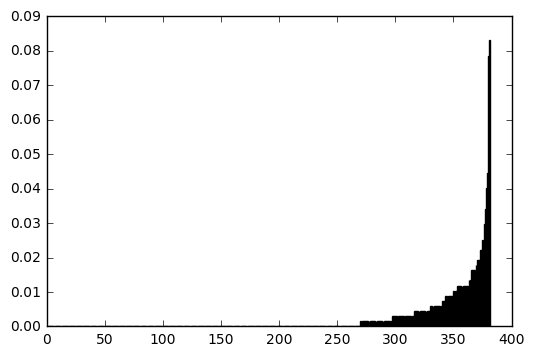

In [9]:
from xgboost import plot_importance
"""plot_importance(model)
plt.show()"""

plt.bar(range(len(model.feature_importances_)), np.sort(model.feature_importances_))
plt.show()

In [34]:
np.mean(model.feature_importances_)

0.0026178011

In [41]:
from sklearn.feature_selection import SelectFromModel
# select features using threshold
selection = SelectFromModel(model, threshold=np.mean(model.feature_importances_), prefit = True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, Y_train)
# eval model
select_X_test = selection.transform(X_test)
pred_select = selection_model.predict(select_X_test)
xgb_test_accuracy(pred_select, Y_test)/len(Y_test)

0.777

In [46]:
def sample_submission_selectionfeature(leanred_clf, selection_fromtrain):
    import csv
    with open('test_2008.csv','r') as bv_data2:
        data_iter = csv.reader(bv_data2, delimiter = ',', quotechar = '"') 
        next(data_iter, None) 
        data = [data for data in data_iter] 
    
    data_array2 = np.asarray(data,dtype=np.float32)
    dim = len(data_array2)
    train_data = np.hstack((np.ones(dim).reshape(dim,1),data_array2[:,1:]))  
    X_test_out = data_array2[:, :382];
    select_X_test_out = selection_fromtrain.transform(X_test_out)
    y_test2 = leanred_clf.predict(select_X_test_out)
    y_test2[y_test2 == 0] = 2
    y_test2 = np.int8(y_test2)
    with open('submission2008.csv', 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(['id', 'PES1'])
        for i, yi in enumerate(y_test2):
            spamwriter.writerow([str(i), str(yi)])
            

def sample_submission_2008(leanred_clf):
    y_test1 = leanred_clf.predict(X_test1)
    y_test1 = y_test1/2.0 + 1.5
    y_test1 = np.int8(y_test1)
    with open('submission2008.csv', 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(['id', 'PES1'])
        for i, yi in enumerate(y_test1):
            spamwriter.writerow([str(i), str(yi)])  

In [47]:
sample_submission_2008(clf)

In [28]:
import csv
with open('test_2008.csv','r') as bv_data2:
    data_iter = csv.reader(bv_data2, delimiter = ',', quotechar = '"') 
    next(data_iter, None) 
    data = [data for data in data_iter] 

data_array2 = np.asarray(data,dtype=np.float32)
dim = len(data_array2)
train_data = np.hstack((np.ones(dim).reshape(dim,1),data_array2[:,1:])) 
X_test_out = data_array2[:, :382];
select_X_test_out = selection.transform(X_test_out)
y_test2 = selection_model.predict(select_X_test_out)
y_test2[y_test2 == 0] = 2
y_test2 = np.int8(y_test2)
with open('submission2008.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'PES1'])
    for i, yi in enumerate(y_test2):
        spamwriter.writerow([str(i), str(yi)])



ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381']
training data did not have the following fields: f75, f84, f209, f361, f42, f261, f278, f263, f207, f135, f256, f216, f252, f205, f166, f275, f134, f155, f71, f334, f336, f296, f195, f308, f253, f226, f127, f196, f109, f112, f86, f37, f245, f324, f191, f41, f148, f227, f355, f160, f340, f99, f206, f366, f132, f152, f270, f234, f200, f320, f211, f312, f249, f343, f362, f161, f285, f348, f189, f83, f360, f110, f247, f376, f181, f74, f80, f218, f317, f367, f68, f147, f346, f125, f332, f116, f137, f139, f276, f208, f164, f354, f178, f325, f61, f293, f45, f103, f180, f294, f96, f221, f213, f203, f171, f33, f290, f356, f168, f115, f370, f55, f35, f87, f54, f353, f224, f327, f358, f302, f365, f124, f267, f184, f64, f97, f212, f120, f78, f299, f49, f186, f50, f262, f82, f150, f369, f219, f326, f77, f129, f121, f265, f141, f51, f108, f138, f347, f266, f339, f372, f284, f66, f338, f214, f56, f251, f44, f62, f40, f328, f122, f105, f175, f101, f271, f89, f92, f65, f130, f39, f85, f106, f289, f73, f292, f53, f229, f204, f95, f329, f165, f133, f307, f352, f230, f248, f149, f157, f373, f298, f260, f304, f70, f243, f303, f69, f237, f79, f235, f46, f257, f114, f58, f179, f185, f318, f159, f142, f57, f156, f333, f67, f158, f241, f305, f364, f151, f228, f269, f379, f81, f217, f107, f232, f222, f220, f52, f244, f199, f246, f190, f131, f331, f59, f287, f342, f117, f357, f375, f136, f163, f378, f202, f162, f349, f38, f288, f286, f371, f210, f192, f264, f295, f153, f194, f123, f126, f255, f323, f377, f60, f374, f146, f250, f43, f282, f177, f215, f198, f113, f173, f259, f145, f48, f187, f363, f90, f315, f337, f128, f233, f309, f311, f225, f381, f94, f140, f306, f281, f319, f297, f154, f300, f223, f341, f63, f76, f182, f322, f335, f310, f47, f301, f93, f176, f231, f368, f313, f279, f280, f344, f102, f119, f88, f118, f104, f351, f283, f316, f277, f188, f314, f34, f143, f238, f359, f380, f291, f242, f258, f98, f321, f197, f144, f345, f274, f72, f201, f330, f174, f183, f272, f167, f170, f32, f240, f100, f193, f172, f111, f239, f91, f254, f273, f350, f236, f36, f169, f268

In [24]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

(16000, 382)

In [23]:
y_test2

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])